# Importing the libraries and seting the paths

In [77]:
from utils import open_nea_table, download_nea_table
from mass_year import mass_vs_year_plot, planet_discovery_stat
import pandas as pd
import numpy as np
import os
import sys
from datetime import date
import math

from mr_ml_utils import a_from_P, Teq_from_teff_v_plx_a, Teq_from_teff_v_plx_P, teq_hellper_function, a_from_P

If needed to update the NEA table then first run  "download_nea_table"

In [78]:
nea_full_table = open_nea_table()
nea_full_table.head(3)

/home/vadibekyan/my_github/ExoPLots/utils.py:52: DtypeWarning:

Columns (65,187) have mixed types. Specify dtype option on import or set low_memory=False.



,pl_name,pl_letter,hostname,hd_name,hip_name,tic_id,gaia_id,default_flag,pl_refname,sy_refname,...,sy_jmagerr1,sy_jmagerr2,sy_jmagstr,sy_hmag,sy_hmagerr1,sy_hmagerr2,sy_hmagstr,sy_kmag,sy_kmagerr1,sy_kmagerr2
0,OGLE-TR-10 b,b,OGLE-TR-10,NaN,NaN,TIC 130150682,Gaia DR2 4056443366649948160,1,<a refstr=TORRES_ET_AL__2008 href=https://ui.a...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,NaN,NaN,13.692,13.314,0.121,-0.121,13.314&plusmn;0.121,12.856,NaN,NaN
1,BD-08 2823 c,c,BD-08 2823,NaN,HIP 49067,TIC 33355302,Gaia DR2 3770419611540574080,1,<a refstr=HEBRARD_ET_AL__2010 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,0.020,-0.020,7.96&plusmn;0.02,7.498,0.047,-0.047,7.498&plusmn;0.047,7.323,0.021,-0.021
2,HR 8799 c,c,HR 8799,HD 218396,HIP 114189,TIC 245368902,Gaia DR2 2832463659640297472,1,<a refstr=MAROIS_ET_AL__2008 href=https://ui.a...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,0.027,-0.027,5.383&plusmn;0.027,5.280,0.018,-0.018,5.280&plusmn;0.018,5.240,0.018,-0.018


In [79]:
nea_full_table.columns.values

array(['pl_name', 'pl_letter', 'hostname', 'hd_name', 'hip_name',
       'tic_id', 'gaia_id', 'default_flag', 'pl_refname', 'sy_refname',
       'disc_pubdate', 'disc_year', 'discoverymethod', 'disc_locale',
       'disc_facility', 'disc_instrument', 'disc_telescope',
       'disc_refname', 'ra', 'rastr', 'dec', 'decstr', 'glon', 'glat',
       'elon', 'elat', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2',
       'pl_orbperlim', 'pl_orbperstr', 'pl_orblpererr1', 'pl_orblper',
       'pl_orblpererr2', 'pl_orblperlim', 'pl_orblperstr', 'pl_orbsmax',
       'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim',
       'pl_orbsmaxstr', 'pl_orbincl', 'pl_orbinclerr1', 'pl_orbinclerr2',
       'pl_orbincllim', 'pl_orbinclstr', 'pl_orbtper', 'pl_orbtpererr1',
       'pl_orbtpererr2', 'pl_orbtperlim', 'pl_orbtperstr', 'pl_orbeccen',
       'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim',
       'pl_orbeccenstr', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2',
       'pl_eqtlim', 'pl_eqtstr', 'pl_oc

# Selecting columns that are relevant for the ML analysis

In [80]:
relevant_columns = ['pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_orbsmax', 'pl_bmasse', 'pl_masseerr1', 'pl_masseerr2', 'pl_orbper',  'sy_vmag', 'sy_plx', 'st_teff', 'st_mass']
nea_relevant = nea_full_table[relevant_columns]


### Equilibrium temperature is important for the radius of hot planets. 

Selecting planets with Mass and Radius measurements for ML

In [81]:
nea_with_M_and_R = nea_relevant[(nea_relevant.pl_bmasse > 0) & (nea_relevant.pl_rade > 0) ].reset_index(drop=True) # reset index, drop old ones

print (f'There are {len(nea_with_M_and_R)} planets with mass and radius measurements')

nea_with_M_and_R.describe()

There are 1113 planets with mass and radius measurements


,pl_rade,pl_radeerr1,pl_radeerr2,pl_orbsmax,pl_bmasse,pl_masseerr1,pl_masseerr2,pl_orbper,sy_vmag,sy_plx,st_teff,st_mass
count,1113.000000,1089.000000,1089.000000,878.000000,1113.000000,993.000000,993.000000,1.098000e+03,1110.000000,1085.000000,1032.000000,1100.000000
mean,8.967707,0.663302,-0.575284,17.160037,420.861732,62.765269,-59.203874,3.790530e+05,12.274946,9.295143,5483.824806,1.003882
std,6.083019,1.022459,0.798818,272.583363,963.110129,243.492003,229.348953,1.213509e+07,2.171725,17.976954,1361.837200,0.345527
min,0.310000,0.006000,-6.730000,0.006000,0.070000,0.012000,-4767.450000,2.401040e-01,5.569110,-0.149186,575.000000,0.010000
25%,2.630000,0.119000,-0.695000,0.037958,10.100000,2.120000,-41.317900,3.003277e+00,11.012500,1.939290,5016.000000,0.820000
50%,10.447000,0.336000,-0.325000,0.053735,126.496340,14.937940,-14.302350,4.603155e+00,12.247000,3.516790,5620.000000,1.000000
75%,13.787000,0.785000,-0.110000,0.100075,379.000000,43.541000,-2.000000,1.189179e+01,13.688000,7.961470,6009.000000,1.180000
max,33.600000,10.536000,0.000000,7506.000000,9534.900000,4767.450000,-0.012000,4.020000e+08,20.154400,153.081000,27730.000000,2.780000


There seem to be star(s) with negative parallaxes. They must be removed fromthe sample

In [82]:
nea_with_M_and_R = nea_with_M_and_R[nea_with_M_and_R.sy_plx > 0]

To calculate Teq, one needs Luminosity (us such, Teff, Vmag, and Plx) and semimajor axis (or orbital period ond Mstar)

In [83]:
#check how many nan values have in each column
nea_with_M_and_R.isna().sum()

pl_rade           0
pl_radeerr1      22
pl_radeerr2      22
pl_orbsmax      234
pl_bmasse         0
pl_masseerr1    118
pl_masseerr2    118
pl_orbper        13
sy_vmag           0
sy_plx            0
st_teff          78
st_mass          11
dtype: int64

There are 235 missing entries for semimajor axis. This parameter can be estimated from the stellar mass and orbital period.

Next, all the rows containing nan values will be removed, except if the nan is in the "pl_orbsmax" column

In [84]:
nea_with_M_and_R_cleaned = nea_with_M_and_R.dropna(subset=nea_with_M_and_R.columns.drop('pl_orbsmax'))
# Check results
nea_with_M_and_R_cleaned.isna().sum()


pl_rade           0
pl_radeerr1       0
pl_radeerr2       0
pl_orbsmax      164
pl_bmasse         0
pl_masseerr1      0
pl_masseerr2      0
pl_orbper         0
sy_vmag           0
sy_plx            0
st_teff           0
st_mass           0
dtype: int64

In [85]:
print (f'There are {len(nea_with_M_and_R_cleaned)} planets for the ML analysis')
nea_with_M_and_R_cleaned.head(3)

There are 880 planets for the ML analysis


,pl_rade,pl_radeerr1,pl_radeerr2,pl_orbsmax,pl_bmasse,pl_masseerr1,pl_masseerr2,pl_orbper,sy_vmag,sy_plx,st_teff,st_mass
0,14.011,1.569,-1.345,0.0434,197.04600,44.49400,-44.49400,3.101278,16.006,0.72138,5950.0,1.14
4,16.870,0.560,-0.504,0.0535,271.74465,22.88376,-21.93027,3.899052,12.006,1.73126,5941.0,1.34
5,21.633,5.044,-5.044,NaN,352.79130,171.62820,-171.62820,2.175180,11.965,1.29679,6100.0,1.87


Calculating semimajor axis from Period and stellar mass, for the missing "a" entries

In [86]:
for i in range(len(nea_with_M_and_R_cleaned)):
    if np.isnan(nea_with_M_and_R_cleaned.iloc[i]['pl_orbsmax']):
        nea_with_M_and_R_cleaned.iloc[i]['pl_orbsmax'] = a_from_P(nea_with_M_and_R_cleaned.iloc[i]['st_mass'], nea_with_M_and_R_cleaned.iloc[i]['pl_orbper'])


Calculating Teq from "a" or "P" 

Use teq_hellper_function function to determine Teq from "a" or "P" depending on their availability. Priority is given to "a"

In [87]:
# Add new columns: Teq
nea_with_M_and_R_cleaned['Teq'] = 0

nea_with_M_and_R_cleaned = nea_with_M_and_R_cleaned.apply(lambda x: teq_hellper_function(x, 'pl_orbsmax', 'pl_orbper', 'st_teff', 'sy_vmag', 'sy_plx', 'st_mass', 'Teq'), axis = 1)

/tmp/ipykernel_1227951/293283582.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [88]:
# very 'cool' planets
print (display(nea_with_M_and_R_cleaned[nea_with_M_and_R_cleaned.Teq < 100]))

#Some of the parameters used to calculate the Teq must be wrong. These objects should be removed

nea_with_M_and_R_cleaned = nea_with_M_and_R_cleaned[nea_with_M_and_R_cleaned.Teq > 10]

,pl_rade,pl_radeerr1,pl_radeerr2,pl_orbsmax,pl_bmasse,pl_masseerr1,pl_masseerr2,pl_orbper,sy_vmag,sy_plx,st_teff,st_mass,Teq
526,21.196,0.684,-0.594,0.03462,915.35040,266.97720,-266.97720,1.481124e+00,7.55000,4.86254,10170.0,2.52,0.0
690,20.288,1.009,-1.009,0.05580,527.59780,38.13960,-38.13960,3.344829e+00,9.94600,2.31187,9360.0,2.07,0.0
696,18.147,0.235,-0.235,0.05053,632.47853,50.85255,-44.49598,2.724033e+00,6.59776,9.99903,8000.0,2.03,0.0
1058,12.442,0.336,-0.336,7506.00000,2002.31896,476.74261,-603.87397,4.020000e+08,11.29800,91.82910,3406.0,0.37,1.0


None


### Selecting plaents with relatively high precision in Mass and Radius

In [89]:
# calculating the mean errors of M and R
nea_with_M_and_R_cleaned['pl_rade_err'] = (nea_with_M_and_R_cleaned['pl_radeerr1'] - nea_with_M_and_R_cleaned['pl_radeerr2'])/2
nea_with_M_and_R_cleaned['pl_bmasse_err'] = (nea_with_M_and_R_cleaned['pl_masseerr1'] - nea_with_M_and_R_cleaned['pl_masseerr2'])/2

In [90]:
M_threshold = 0.25
R_threshold = 0.25
precise_criteria = (nea_with_M_and_R_cleaned['pl_rade_err']/nea_with_M_and_R_cleaned['pl_rade'] < R_threshold) & (nea_with_M_and_R_cleaned['pl_bmasse_err']/nea_with_M_and_R_cleaned['pl_bmasse'] < M_threshold)
nea_with_M_and_R_cleaned_accurate = nea_with_M_and_R_cleaned[precise_criteria]

print (f'There are {len(nea_with_M_and_R_cleaned_accurate)} precisely characterized planets in terms of Mass and Radius')

There are 708 precisely characterized planets in terms of Mass and Radius


In [91]:
# Final table with Mass, Radius, and Teq
nea_MR_final_table = nea_with_M_and_R_cleaned_accurate[['pl_rade', 'pl_bmasse', 'Teq', 'st_teff', 'pl_orbsmax']]
nea_MR_final_table.head(2)

,pl_rade,pl_bmasse,Teq,st_teff,pl_orbsmax
0,14.011,197.04600,1194.0,5950.0,0.0434
4,16.870,271.74465,1744.0,5941.0,0.0535


# Starting the Machine Learning part

Since the accuracy of Mass estimation is not critical, I'll make things simple (but still keeping the state-of-the-art): 

Use XGBoost regressor and tune HyperParameters with "optuna" (sometimes better than grid_search see e.g. [this](https://medium.com/mlearning-ai/hyper-parameter-tuning-through-grid-search-and-optuna-2bd89a2ece06)

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Displaying the data

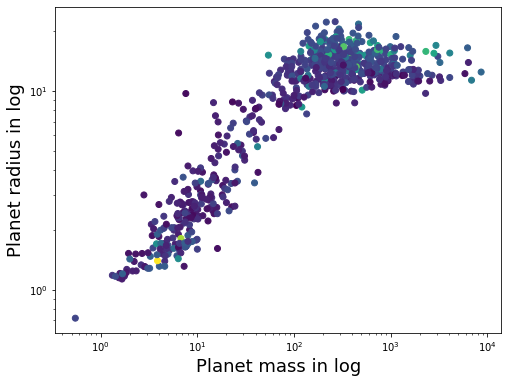

In [93]:
fig = plt.figure(1, figsize = (8,6))
ax = plt.gca()

ax = plt.subplot(1,1,1)

ax.scatter(nea_MR_final_table.pl_bmasse, nea_MR_final_table.pl_rade, c = nea_MR_final_table['Teq'])
ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel('Planet mass in log', fontsize = 18)
plt.ylabel('Planet radius in log', fontsize = 18)

plt.show()

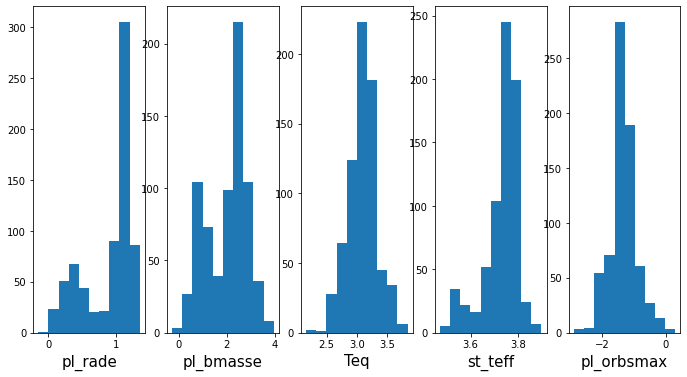

In [94]:
fig = plt.figure(2, figsize = (14,6))
ax = plt.gca()

for i, col  in enumerate(nea_MR_final_table.columns):
    ax = plt.subplot(1, 6, i+1)

    ax.hist(np.log10(nea_MR_final_table[col]))
    ax.set_xlabel(col, fontsize = 15)

### The Mass and Radius have bimodal (and also assymetric) distributions... 

In [121]:
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from  xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [158]:
y = nea_MR_final_table['pl_bmasse']
X = nea_MR_final_table.drop(columns = ['pl_bmasse'])

# Spliting data into train, dev, and test (70%, 15%, 15%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print (f'Sizes of the samples:\nTrain = {len(X_train)}, Test = {len(X_test)}')

Sizes of the samples:
Train = 566, Test = 142


In [160]:

def score_dataset(X, y, model):
    score = cross_val_score(
        model, X, y, cv=5, scoring='neg_mean_absolute_error',
        )
    rms = (-1*score)
    return rms.mean()

XGB_model_base = XGBRegressor(random_state =0)
RFR_base_model = RandomForestRegressor(random_state =0)
MAE_base = score_dataset(X_train, y_train, RFR_base_model)

print (f'The base MAE score for the full data is {MAE_base:.0f}')

The base MAE score for the full data is 279


In [169]:
mean_mass = [np.mean(y_train)]*len(y_train)


MAE_base_base = mean_absolute_error(y_train, mean_mass)
MAE_base_base


389.705988611732

In [98]:
# A package for hyperparameters tuning
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_param_importances


In [165]:
def opt_hyperParameters_TFReg(X_train, y_train, X_test, y_test):

    def objective(trial):

        RF_reg_params = dict(
            n_estimators=trial.suggest_int("n_estimators", 20, 200, step = 20),
            max_depth=trial.suggest_int("max_depth", 1, 20),
            min_samples_split = trial.suggest_int("min_samples_split", 2, 20),
            min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10),
            max_features = trial.suggest_int("max_features", 1, 5),
            random_state = 0
        )

        RF_reg = RandomForestRegressor(**RF_reg_params).fit(X_train, y_train)
        #y_pred= rfr.predict(X_dev)
        #mae = mean_absolute_error(y_dev, y_pred)
        mae = score_dataset(X_train, y_train, RF_reg)
        return mae

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)
    RFR_best_params = study.best_params
    

    fig = plt.figure()
    plot_param_importances(study).show()
    plot_contour(study).show()
    print (f'The best hyperparameters for RF Regressor {RFR_best_params}')

    y_train_predict = RandomForestRegressor(**RFR_best_params).fit(X_train, y_train).predict(X_train)
    y_test_predict = RandomForestRegressor(**RFR_best_params).fit(X_train, y_train).predict(X_test)
    print (f'RMS of the BEST XGBoost Regressor\n: Training data {(mean_absolute_error(y_train, y_train_predict))}\n Test data {(mean_absolute_error(y_test, y_test_predict))}')

    return RFR_best_params


RFR_best_params = opt_hyperParameters_TFReg(X_train, y_train,  X_test, y_test)

[I 2023-07-10 17:42:55,047] A new study created in memory with name: no-name-281f0994-2a16-49a1-bb84-97fa987a0141


[I 2023-07-10 17:42:56,014] Trial 0 finished with value: 301.43305375914196 and parameters: {'n_estimators': 120, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 1}. Best is trial 0 with value: 301.43305375914196.
[I 2023-07-10 17:42:56,516] Trial 1 finished with value: 313.27341417674563 and parameters: {'n_estimators': 60, 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': 2}. Best is trial 0 with value: 301.43305375914196.
[I 2023-07-10 17:42:57,582] Trial 2 finished with value: 300.52143236899076 and parameters: {'n_estimators': 120, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 3}. Best is trial 2 with value: 300.52143236899076.
[I 2023-07-10 17:42:58,539] Trial 3 finished with value: 304.03386539977964 and parameters: {'n_estimators': 120, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 1}. Best is trial 2 with value: 300.52143236899076.
[I 2023-07-10 17:4

The best hyperparameters for RF Regressor {'n_estimators': 160, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 5}
RMS of the BEST XGBoost Regressor
: Training data 229.56098493727254
 Test data 290.52211329491536


<Figure size 432x288 with 0 Axes>


0
For a training size of 169, MAE(train) = 217.348 and MAE(test) = 285.450
1
For a training size of 267, MAE(train) = 237.456 and MAE(test) = 293.582
2
For a training size of 365, MAE(train) = 231.279 and MAE(test) = 293.629
3
For a training size of 462, MAE(train) = 232.897 and MAE(test) = 294.222
4
For a training size of 560, MAE(train) = 229.758 and MAE(test) = 292.166


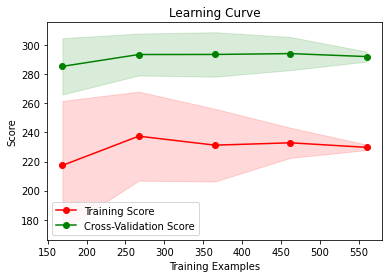

In [166]:
def my_learning_curve(X_train, y_train, X_test, y_test, model, N, CV = 10, figure = True):

    train_sizes =np.linspace(0.3, 0.99, N)
    print ()

    results = pd.DataFrame(columns = ['train_size', 'mae_train_mean', 'mae_train_std', 'mae_test_mean', 'mae_test_std'], index = range(0, N))


    for i, train_size in enumerate(train_sizes):

        print (i)

        mae_train = []
        mae_test = []

        for j in range(CV):

                # Random state is not specified as cross-validation is applied.
                X_train_tmp, _, y_train_tmp, _ = train_test_split(X_train, y_train, test_size=(1-train_size))

                model.fit(X_train_tmp, y_train_tmp)

                # Make predictions on the test set
                y_pred_test = model.predict(X_test)
                y_pred_train_tmp = model.predict(X_train_tmp)

                # Evaluate the model using mean absolute error
                mae_train.append(mean_absolute_error(y_train_tmp, y_pred_train_tmp))
                mae_test.append(mean_absolute_error(y_test, y_pred_test))

        
        results['train_size'][i] = len(X_train_tmp)
        results['mae_train_mean'][i] = np.mean(mae_train)
        results['mae_train_std'][i] = np.std(mae_train)
        results['mae_test_mean'][i] = np.mean(mae_test)
        results['mae_test_std'][i] = np.std(mae_test)

        if i%1 ==0:
            print (f'For a training size of {len(X_train_tmp)}, MAE(train) = {np.mean(mae_train):.3f} and MAE(test) = {np.mean(mae_test):.3f}')

    # Iterate over each column in the DataFrame
    for column in results.columns:
        # Check if the column has object data type
        if results[column].dtype == 'object':
            # Convert the column to numeric type
            results[column] = pd.to_numeric(results[column], errors='coerce')

    if figure == True:
        plt.figure()
        plt.title("Learning Curve")
        plt.xlabel("Training Examples")
        plt.ylabel("Score")

        plt.plot(results['train_size'], results['mae_train_mean'], 'o-', color="r",
                label="Training Score")

        plt.fill_between(results['train_size'], results['mae_train_mean'] + results['mae_train_std'], 
                            results['mae_train_mean'] - results['mae_train_std'], 
                            alpha=0.15, color='r')

        plt.plot(results['train_size'], results['mae_test_mean'], 'o-', color="g",
                label="Cross-Validation Score")

        plt.fill_between(results['train_size'], results['mae_test_mean'] + results['mae_test_std'], 
                            results['mae_test_mean'] - results['mae_test_std'], 
                            alpha=0.15, color='g')

        plt.legend(loc="best")
        plt.show()
    
    return results


#The best hyperparameters for XGBoost Regressor {'max_depth': 17, 'reg_alpha': 6, 'reg_lambda': 4.446321108649305, 'n_estimators': 300}
        
#best_XGBReg = XGBRegressor(max_depth = 5, reg_alpha = 5, reg_lambda = 30)
best_RF = RandomForestRegressor(n_estimators = 20, max_depth = 5, min_samples_split = 3, max_features = 4)
results = my_learning_curve(X_train, y_train, X_test, y_test, RandomForestRegressor(**RFR_best_params), 5)

In [164]:
RFR_best_params

{'n_estimators': 120,
 'max_depth': 17,
 'min_samples_split': 9,
 'min_samples_leaf': 7,
 'max_features': 6}

In [184]:
best_RF = RandomForestRegressor(**RFR_best_params).fit(X_train, y_train)
y_pred = best_RF.predict(X_test)

print ((X_test))

      pl_rade     Teq  st_teff  pl_orbsmax
374     1.510  1947.0   4570.0     0.00747
466     2.299  1104.0   5356.3     0.04461
1109    4.570   699.0   3600.0     0.03550
1011    2.630   787.0   5450.0     0.10110
402    16.030  1669.0   6440.0     0.04360
...       ...     ...      ...         ...
508    14.975  1581.0   5650.0     0.02282
308     3.020  1472.0   4960.0     0.02290
435    13.340  1035.0   6190.0     0.09000
980     4.700   695.0   3950.0     0.04170
9      13.115  1018.0   6295.0     0.10380

[142 rows x 4 columns]


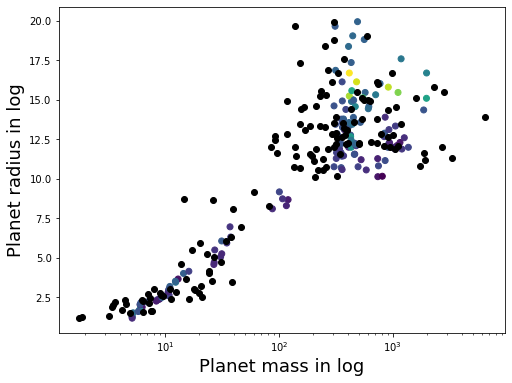

In [189]:
fig = plt.figure(1, figsize = (8,6))
ax = plt.gca()

ax = plt.subplot(1,1,1)

ax.scatter(y_pred, X_test.pl_rade, c = X_test.Teq)
ax.scatter(y_test, X_test.pl_rade, c = 'black')

ax.set_xscale('log')
#ax.set_yscale('log')

plt.xlabel('Planet mass in log', fontsize = 18)
plt.ylabel('Planet radius in log', fontsize = 18)

plt.show()

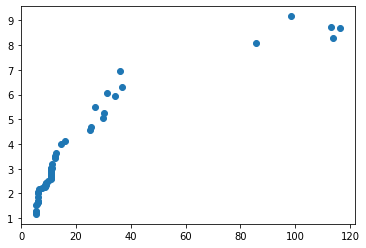

In [182]:
plt.scatter(y_pred, X_test[X_test.pl_rade <10].pl_rade)